In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print(tf.__version__)
# Mac OS jupyter kernel dies without
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2.1.0


### Define density network model parameterized by Real NVP.

In [2]:
from tensorflow.keras import Model

class DensityNetwork(Model):
    def __init__(self, D, num_layers, num_units):
        super(DensityNetwork, self).__init__()
        self.D = D
        self.num_masked = D//2
        self.shift_and_log_scale_fn = tfb.real_nvp_default_template(
                                          hidden_layers=num_layers*[num_units])
        self.a = tf.Variable(tf.ones((2,))) 
        self.b = tf.Variable(tf.zeros((2,)))        
        
    def __call__(self, N):
        """self.nvp = tfb.RealNVP(
            num_masked=self.num_masked,
            shift_and_log_scale_fn=self.shift_and_log_scale_fn
        )"""
        scale = tfb.Scale(scale=self.a)
        shift = tfb.Shift(shift=self.b)
        self.bij = tfb.Chain([shift, scale])
        self.q = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=D*[0.]),
            bijector=self.bij
        )
        x = self.q.sample(N)
        H = self.q.entropy()
        return x, H
    
    def log_prob(self, x):
        return self.q.log_prob(x)
        

In [3]:
D = 2
num_layers = 2
num_units = 10 # units per layer
lr = 1e-1

dn = DensityNetwork(D, num_layers, num_units)
optimizer = tf.keras.optimizers.Adam(lr)

In [4]:
def gaussian_eta(mu, Sigma):
    n = mu.shape[0]
    Sigma_inv = np.linalg.inv(Sigma)
    x = np.dot(Sigma_inv, mu)
    y = np.reshape(-0.5*Sigma_inv, (n**2))
    eta = np.concatenate((x[:,0], y), 
                         axis=0)
    return eta


N = 100
mu = np.array([[10.0], [10.0]])
Sigma = np.eye(2)

def train_step():
    n = mu.shape[0]
    eta = gaussian_eta(mu, Sigma)
    with tf.GradientTape() as tape:
        x, H = dn(N)
        xl = x[:,:,tf.newaxis]
        xr = x[:,tf.newaxis,:]
        xxT = tf.matmul(xl, xr)
        xxT_vec = tf.reshape(xxT, (N,n**2))
        T_x = tf.concat((x, xxT_vec), axis=1)
        E_T_x = tf.reduce_mean(T_x, axis=0)
        
        print('H', H)
        term2 = - tf.reduce_sum(eta*E_T_x)
        print('term2', term2)
        loss = -H + term2
    
    params = dn.trainable_variables
    gradients = tape.gradient(loss, params)
        
    optimizer.apply_gradients(zip(gradients, params))
    return loss

H tf.Tensor(2.837877, shape=(), dtype=float32)
term2 tf.Tensor(0.061771274, shape=(), dtype=float32)
0 tf.Tensor(-2.7761059, shape=(), dtype=float32) took 0.0499 seconds


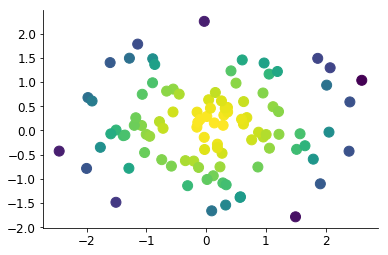

H tf.Tensor(2.8278317, shape=(), dtype=float32)
term2 tf.Tensor(-3.077493, shape=(), dtype=float32)
H tf.Tensor(2.9835408, shape=(), dtype=float32)
term2 tf.Tensor(-4.700325, shape=(), dtype=float32)
H tf.Tensor(3.1349735, shape=(), dtype=float32)
term2 tf.Tensor(-3.6650326, shape=(), dtype=float32)
H tf.Tensor(3.2060869, shape=(), dtype=float32)
term2 tf.Tensor(-9.009649, shape=(), dtype=float32)
H tf.Tensor(3.2878544, shape=(), dtype=float32)
term2 tf.Tensor(-8.772402, shape=(), dtype=float32)
H tf.Tensor(3.3446085, shape=(), dtype=float32)
term2 tf.Tensor(-12.293885, shape=(), dtype=float32)
H tf.Tensor(3.400682, shape=(), dtype=float32)
term2 tf.Tensor(-14.194084, shape=(), dtype=float32)
H tf.Tensor(3.4560008, shape=(), dtype=float32)
term2 tf.Tensor(-15.23274, shape=(), dtype=float32)
H tf.Tensor(3.5032732, shape=(), dtype=float32)
term2 tf.Tensor(-14.749001, shape=(), dtype=float32)
H tf.Tensor(3.5199783, shape=(), dtype=float32)
term2 tf.Tensor(-18.499344, shape=(), dtype=float

H tf.Tensor(2.8623548, shape=(), dtype=float32)
term2 tf.Tensor(-90.53157, shape=(), dtype=float32)
H tf.Tensor(2.8879335, shape=(), dtype=float32)
term2 tf.Tensor(-90.33661, shape=(), dtype=float32)
H tf.Tensor(2.9145417, shape=(), dtype=float32)
term2 tf.Tensor(-90.16378, shape=(), dtype=float32)
H tf.Tensor(2.9363933, shape=(), dtype=float32)
term2 tf.Tensor(-90.9063, shape=(), dtype=float32)
H tf.Tensor(2.9575648, shape=(), dtype=float32)
term2 tf.Tensor(-91.86931, shape=(), dtype=float32)
H tf.Tensor(2.9845932, shape=(), dtype=float32)
term2 tf.Tensor(-91.1718, shape=(), dtype=float32)
H tf.Tensor(3.0058956, shape=(), dtype=float32)
term2 tf.Tensor(-91.768, shape=(), dtype=float32)
H tf.Tensor(3.0245862, shape=(), dtype=float32)
term2 tf.Tensor(-92.130325, shape=(), dtype=float32)
H tf.Tensor(3.0438802, shape=(), dtype=float32)
term2 tf.Tensor(-91.073456, shape=(), dtype=float32)
H tf.Tensor(3.0462031, shape=(), dtype=float32)
term2 tf.Tensor(-92.37892, shape=(), dtype=float32)
H 

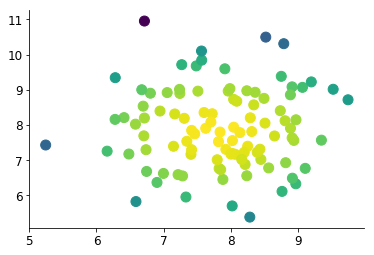

H tf.Tensor(2.9986477, shape=(), dtype=float32)
term2 tf.Tensor(-94.245964, shape=(), dtype=float32)
H tf.Tensor(2.991468, shape=(), dtype=float32)
term2 tf.Tensor(-94.506256, shape=(), dtype=float32)
H tf.Tensor(2.986291, shape=(), dtype=float32)
term2 tf.Tensor(-94.650925, shape=(), dtype=float32)
H tf.Tensor(2.9788516, shape=(), dtype=float32)
term2 tf.Tensor(-94.11291, shape=(), dtype=float32)
H tf.Tensor(2.9591138, shape=(), dtype=float32)
term2 tf.Tensor(-94.84865, shape=(), dtype=float32)
H tf.Tensor(2.9369268, shape=(), dtype=float32)
term2 tf.Tensor(-95.206116, shape=(), dtype=float32)
H tf.Tensor(2.918379, shape=(), dtype=float32)
term2 tf.Tensor(-95.52696, shape=(), dtype=float32)
H tf.Tensor(2.900711, shape=(), dtype=float32)
term2 tf.Tensor(-95.47764, shape=(), dtype=float32)
H tf.Tensor(2.8838642, shape=(), dtype=float32)
term2 tf.Tensor(-95.73505, shape=(), dtype=float32)
H tf.Tensor(2.8681953, shape=(), dtype=float32)
term2 tf.Tensor(-95.4048, shape=(), dtype=float32)
H

H tf.Tensor(2.9277153, shape=(), dtype=float32)
term2 tf.Tensor(-98.67197, shape=(), dtype=float32)
H tf.Tensor(2.9066608, shape=(), dtype=float32)
term2 tf.Tensor(-98.77116, shape=(), dtype=float32)
H tf.Tensor(2.881642, shape=(), dtype=float32)
term2 tf.Tensor(-98.97046, shape=(), dtype=float32)
H tf.Tensor(2.8597276, shape=(), dtype=float32)
term2 tf.Tensor(-99.099106, shape=(), dtype=float32)
H tf.Tensor(2.844962, shape=(), dtype=float32)
term2 tf.Tensor(-98.87569, shape=(), dtype=float32)
H tf.Tensor(2.828084, shape=(), dtype=float32)
term2 tf.Tensor(-98.994934, shape=(), dtype=float32)
H tf.Tensor(2.8144464, shape=(), dtype=float32)
term2 tf.Tensor(-98.904205, shape=(), dtype=float32)
H tf.Tensor(2.7996032, shape=(), dtype=float32)
term2 tf.Tensor(-99.03847, shape=(), dtype=float32)
H tf.Tensor(2.789547, shape=(), dtype=float32)
term2 tf.Tensor(-98.75267, shape=(), dtype=float32)
H tf.Tensor(2.771916, shape=(), dtype=float32)
term2 tf.Tensor(-99.08212, shape=(), dtype=float32)
H 

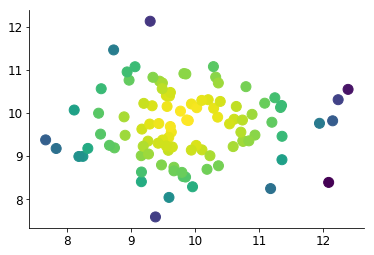

H tf.Tensor(2.79361, shape=(), dtype=float32)
term2 tf.Tensor(-99.11304, shape=(), dtype=float32)
H tf.Tensor(2.8158796, shape=(), dtype=float32)
term2 tf.Tensor(-99.066284, shape=(), dtype=float32)
H tf.Tensor(2.8399978, shape=(), dtype=float32)
term2 tf.Tensor(-98.9034, shape=(), dtype=float32)
H tf.Tensor(2.8583858, shape=(), dtype=float32)
term2 tf.Tensor(-99.07747, shape=(), dtype=float32)
H tf.Tensor(2.8787844, shape=(), dtype=float32)
term2 tf.Tensor(-98.80551, shape=(), dtype=float32)
H tf.Tensor(2.8898427, shape=(), dtype=float32)
term2 tf.Tensor(-99.11406, shape=(), dtype=float32)
H tf.Tensor(2.9047792, shape=(), dtype=float32)
term2 tf.Tensor(-98.7677, shape=(), dtype=float32)
H tf.Tensor(2.9102864, shape=(), dtype=float32)
term2 tf.Tensor(-99.01787, shape=(), dtype=float32)
H tf.Tensor(2.9165404, shape=(), dtype=float32)
term2 tf.Tensor(-99.043495, shape=(), dtype=float32)
H tf.Tensor(2.9242477, shape=(), dtype=float32)
term2 tf.Tensor(-98.87587, shape=(), dtype=float32)
H 

term2 tf.Tensor(-98.787155, shape=(), dtype=float32)
H tf.Tensor(2.9070904, shape=(), dtype=float32)
term2 tf.Tensor(-98.93156, shape=(), dtype=float32)
H tf.Tensor(2.9011555, shape=(), dtype=float32)
term2 tf.Tensor(-98.89104, shape=(), dtype=float32)
H tf.Tensor(2.8907363, shape=(), dtype=float32)
term2 tf.Tensor(-98.81894, shape=(), dtype=float32)
H tf.Tensor(2.8728976, shape=(), dtype=float32)
term2 tf.Tensor(-99.1575, shape=(), dtype=float32)
H tf.Tensor(2.8641946, shape=(), dtype=float32)
term2 tf.Tensor(-98.96076, shape=(), dtype=float32)
H tf.Tensor(2.8543973, shape=(), dtype=float32)
term2 tf.Tensor(-98.93715, shape=(), dtype=float32)
H tf.Tensor(2.842394, shape=(), dtype=float32)
term2 tf.Tensor(-99.117004, shape=(), dtype=float32)
H tf.Tensor(2.8370624, shape=(), dtype=float32)
term2 tf.Tensor(-99.15602, shape=(), dtype=float32)
H tf.Tensor(2.8400617, shape=(), dtype=float32)
term2 tf.Tensor(-98.83168, shape=(), dtype=float32)
300 tf.Tensor(-101.671745, shape=(), dtype=float

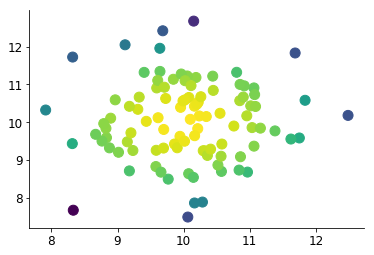

H tf.Tensor(2.8339908, shape=(), dtype=float32)
term2 tf.Tensor(-99.05368, shape=(), dtype=float32)
H tf.Tensor(2.8306847, shape=(), dtype=float32)
term2 tf.Tensor(-98.876465, shape=(), dtype=float32)
H tf.Tensor(2.82154, shape=(), dtype=float32)
term2 tf.Tensor(-99.15038, shape=(), dtype=float32)
H tf.Tensor(2.8215857, shape=(), dtype=float32)
term2 tf.Tensor(-99.06172, shape=(), dtype=float32)
H tf.Tensor(2.8248038, shape=(), dtype=float32)
term2 tf.Tensor(-98.88853, shape=(), dtype=float32)
H tf.Tensor(2.822369, shape=(), dtype=float32)
term2 tf.Tensor(-98.967094, shape=(), dtype=float32)
H tf.Tensor(2.8188195, shape=(), dtype=float32)
term2 tf.Tensor(-99.044586, shape=(), dtype=float32)
H tf.Tensor(2.8188639, shape=(), dtype=float32)
term2 tf.Tensor(-98.91847, shape=(), dtype=float32)
H tf.Tensor(2.81591, shape=(), dtype=float32)
term2 tf.Tensor(-99.09805, shape=(), dtype=float32)
H tf.Tensor(2.8177152, shape=(), dtype=float32)
term2 tf.Tensor(-98.984886, shape=(), dtype=float32)
H

H tf.Tensor(2.836294, shape=(), dtype=float32)
term2 tf.Tensor(-98.83832, shape=(), dtype=float32)
H tf.Tensor(2.8281164, shape=(), dtype=float32)
term2 tf.Tensor(-98.98079, shape=(), dtype=float32)
H tf.Tensor(2.819637, shape=(), dtype=float32)
term2 tf.Tensor(-99.02123, shape=(), dtype=float32)
H tf.Tensor(2.8132038, shape=(), dtype=float32)
term2 tf.Tensor(-99.02864, shape=(), dtype=float32)
H tf.Tensor(2.8089285, shape=(), dtype=float32)
term2 tf.Tensor(-99.085144, shape=(), dtype=float32)
H tf.Tensor(2.809994, shape=(), dtype=float32)
term2 tf.Tensor(-99.245224, shape=(), dtype=float32)
H tf.Tensor(2.8250291, shape=(), dtype=float32)
term2 tf.Tensor(-99.04743, shape=(), dtype=float32)
H tf.Tensor(2.8410325, shape=(), dtype=float32)
term2 tf.Tensor(-98.96889, shape=(), dtype=float32)
H tf.Tensor(2.8532257, shape=(), dtype=float32)
term2 tf.Tensor(-99.00366, shape=(), dtype=float32)
H tf.Tensor(2.8644662, shape=(), dtype=float32)
term2 tf.Tensor(-98.984146, shape=(), dtype=float32)


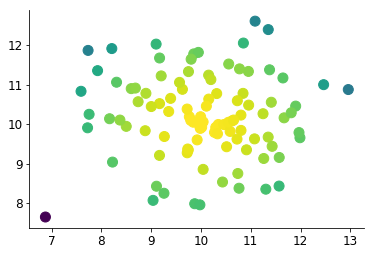

H tf.Tensor(2.9002063, shape=(), dtype=float32)
term2 tf.Tensor(-99.02365, shape=(), dtype=float32)
H tf.Tensor(2.8956954, shape=(), dtype=float32)
term2 tf.Tensor(-99.026855, shape=(), dtype=float32)
H tf.Tensor(2.893827, shape=(), dtype=float32)
term2 tf.Tensor(-98.98231, shape=(), dtype=float32)
H tf.Tensor(2.892094, shape=(), dtype=float32)
term2 tf.Tensor(-98.97423, shape=(), dtype=float32)
H tf.Tensor(2.890727, shape=(), dtype=float32)
term2 tf.Tensor(-98.89989, shape=(), dtype=float32)
H tf.Tensor(2.8836024, shape=(), dtype=float32)
term2 tf.Tensor(-98.854935, shape=(), dtype=float32)
H tf.Tensor(2.8693128, shape=(), dtype=float32)
term2 tf.Tensor(-99.100266, shape=(), dtype=float32)
H tf.Tensor(2.8614068, shape=(), dtype=float32)
term2 tf.Tensor(-99.05246, shape=(), dtype=float32)
H tf.Tensor(2.8570926, shape=(), dtype=float32)
term2 tf.Tensor(-98.949615, shape=(), dtype=float32)
H tf.Tensor(2.8503385, shape=(), dtype=float32)
term2 tf.Tensor(-98.93544, shape=(), dtype=float32)

H tf.Tensor(2.8878715, shape=(), dtype=float32)
term2 tf.Tensor(-98.68316, shape=(), dtype=float32)
H tf.Tensor(2.8589194, shape=(), dtype=float32)
term2 tf.Tensor(-99.02584, shape=(), dtype=float32)
H tf.Tensor(2.83448, shape=(), dtype=float32)
term2 tf.Tensor(-99.10736, shape=(), dtype=float32)
H tf.Tensor(2.8197598, shape=(), dtype=float32)
term2 tf.Tensor(-98.96353, shape=(), dtype=float32)
H tf.Tensor(2.802675, shape=(), dtype=float32)
term2 tf.Tensor(-99.12062, shape=(), dtype=float32)
H tf.Tensor(2.7957616, shape=(), dtype=float32)
term2 tf.Tensor(-99.09984, shape=(), dtype=float32)
H tf.Tensor(2.7974358, shape=(), dtype=float32)
term2 tf.Tensor(-98.9717, shape=(), dtype=float32)
H tf.Tensor(2.7959712, shape=(), dtype=float32)
term2 tf.Tensor(-99.24991, shape=(), dtype=float32)
H tf.Tensor(2.811346, shape=(), dtype=float32)
term2 tf.Tensor(-99.11224, shape=(), dtype=float32)
H tf.Tensor(2.834684, shape=(), dtype=float32)
term2 tf.Tensor(-98.83444, shape=(), dtype=float32)
H tf.T

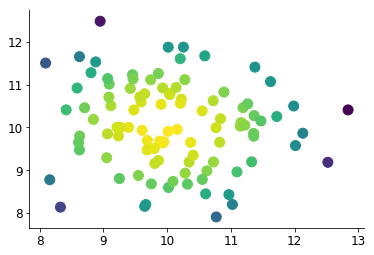

H tf.Tensor(2.8777666, shape=(), dtype=float32)
term2 tf.Tensor(-99.07498, shape=(), dtype=float32)
H tf.Tensor(2.8962579, shape=(), dtype=float32)
term2 tf.Tensor(-98.99865, shape=(), dtype=float32)
H tf.Tensor(2.9124503, shape=(), dtype=float32)
term2 tf.Tensor(-98.894196, shape=(), dtype=float32)
H tf.Tensor(2.9201741, shape=(), dtype=float32)
term2 tf.Tensor(-98.91383, shape=(), dtype=float32)
H tf.Tensor(2.921982, shape=(), dtype=float32)
term2 tf.Tensor(-98.85666, shape=(), dtype=float32)
H tf.Tensor(2.9151828, shape=(), dtype=float32)
term2 tf.Tensor(-98.970505, shape=(), dtype=float32)
H tf.Tensor(2.907221, shape=(), dtype=float32)
term2 tf.Tensor(-98.94635, shape=(), dtype=float32)
H tf.Tensor(2.8968627, shape=(), dtype=float32)
term2 tf.Tensor(-99.01556, shape=(), dtype=float32)
H tf.Tensor(2.8884006, shape=(), dtype=float32)
term2 tf.Tensor(-99.007545, shape=(), dtype=float32)
H tf.Tensor(2.8812308, shape=(), dtype=float32)
term2 tf.Tensor(-98.79932, shape=(), dtype=float32)

H tf.Tensor(2.8785973, shape=(), dtype=float32)
term2 tf.Tensor(-98.916855, shape=(), dtype=float32)
H tf.Tensor(2.8620188, shape=(), dtype=float32)
term2 tf.Tensor(-99.091225, shape=(), dtype=float32)
H tf.Tensor(2.8543184, shape=(), dtype=float32)
term2 tf.Tensor(-98.981476, shape=(), dtype=float32)
H tf.Tensor(2.848219, shape=(), dtype=float32)
term2 tf.Tensor(-99.005775, shape=(), dtype=float32)
H tf.Tensor(2.8440096, shape=(), dtype=float32)
term2 tf.Tensor(-99.025505, shape=(), dtype=float32)
H tf.Tensor(2.843739, shape=(), dtype=float32)
term2 tf.Tensor(-99.058426, shape=(), dtype=float32)
H tf.Tensor(2.8494668, shape=(), dtype=float32)
term2 tf.Tensor(-98.94121, shape=(), dtype=float32)
H tf.Tensor(2.8512049, shape=(), dtype=float32)
term2 tf.Tensor(-98.964096, shape=(), dtype=float32)
H tf.Tensor(2.8497696, shape=(), dtype=float32)
term2 tf.Tensor(-98.98279, shape=(), dtype=float32)
H tf.Tensor(2.8463, shape=(), dtype=float32)
term2 tf.Tensor(-99.05105, shape=(), dtype=float32

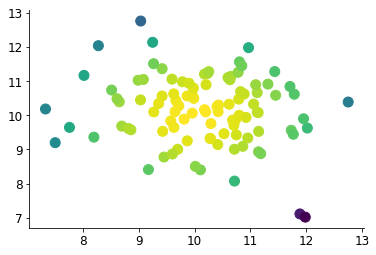

H tf.Tensor(2.8324637, shape=(), dtype=float32)
term2 tf.Tensor(-99.058334, shape=(), dtype=float32)
H tf.Tensor(2.8304594, shape=(), dtype=float32)
term2 tf.Tensor(-98.868484, shape=(), dtype=float32)
H tf.Tensor(2.8198004, shape=(), dtype=float32)
term2 tf.Tensor(-99.06543, shape=(), dtype=float32)
H tf.Tensor(2.8145354, shape=(), dtype=float32)
term2 tf.Tensor(-99.053406, shape=(), dtype=float32)
H tf.Tensor(2.8136811, shape=(), dtype=float32)
term2 tf.Tensor(-99.08426, shape=(), dtype=float32)
H tf.Tensor(2.8190937, shape=(), dtype=float32)
term2 tf.Tensor(-98.953224, shape=(), dtype=float32)
H tf.Tensor(2.82072, shape=(), dtype=float32)
term2 tf.Tensor(-99.06317, shape=(), dtype=float32)
H tf.Tensor(2.82758, shape=(), dtype=float32)
term2 tf.Tensor(-99.09352, shape=(), dtype=float32)
H tf.Tensor(2.8402355, shape=(), dtype=float32)
term2 tf.Tensor(-99.021545, shape=(), dtype=float32)
H tf.Tensor(2.8527484, shape=(), dtype=float32)
term2 tf.Tensor(-99.113815, shape=(), dtype=float32

H tf.Tensor(2.7318542, shape=(), dtype=float32)
term2 tf.Tensor(-99.01564, shape=(), dtype=float32)
H tf.Tensor(2.739108, shape=(), dtype=float32)
term2 tf.Tensor(-99.127655, shape=(), dtype=float32)
H tf.Tensor(2.7555883, shape=(), dtype=float32)
term2 tf.Tensor(-99.013245, shape=(), dtype=float32)
H tf.Tensor(2.7711658, shape=(), dtype=float32)
term2 tf.Tensor(-99.0822, shape=(), dtype=float32)
H tf.Tensor(2.791003, shape=(), dtype=float32)
term2 tf.Tensor(-98.90403, shape=(), dtype=float32)
H tf.Tensor(2.8014483, shape=(), dtype=float32)
term2 tf.Tensor(-99.036736, shape=(), dtype=float32)
H tf.Tensor(2.8135607, shape=(), dtype=float32)
term2 tf.Tensor(-99.03754, shape=(), dtype=float32)
H tf.Tensor(2.8283734, shape=(), dtype=float32)
term2 tf.Tensor(-98.976814, shape=(), dtype=float32)
H tf.Tensor(2.8404956, shape=(), dtype=float32)
term2 tf.Tensor(-98.906494, shape=(), dtype=float32)
H tf.Tensor(2.84483, shape=(), dtype=float32)
term2 tf.Tensor(-99.160446, shape=(), dtype=float32)

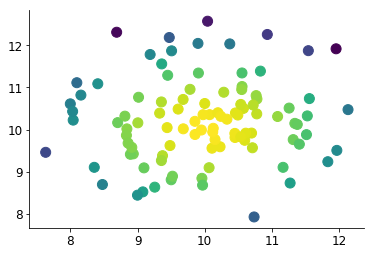

H tf.Tensor(2.8884244, shape=(), dtype=float32)
term2 tf.Tensor(-99.04184, shape=(), dtype=float32)
H tf.Tensor(2.8807068, shape=(), dtype=float32)
term2 tf.Tensor(-98.90115, shape=(), dtype=float32)
H tf.Tensor(2.8674195, shape=(), dtype=float32)
term2 tf.Tensor(-98.86972, shape=(), dtype=float32)
H tf.Tensor(2.8472106, shape=(), dtype=float32)
term2 tf.Tensor(-99.13724, shape=(), dtype=float32)
H tf.Tensor(2.8404899, shape=(), dtype=float32)
term2 tf.Tensor(-98.75609, shape=(), dtype=float32)
H tf.Tensor(2.8163476, shape=(), dtype=float32)
term2 tf.Tensor(-99.02713, shape=(), dtype=float32)
H tf.Tensor(2.7967691, shape=(), dtype=float32)
term2 tf.Tensor(-99.054, shape=(), dtype=float32)
H tf.Tensor(2.7823236, shape=(), dtype=float32)
term2 tf.Tensor(-99.164215, shape=(), dtype=float32)
H tf.Tensor(2.7819064, shape=(), dtype=float32)
term2 tf.Tensor(-99.08142, shape=(), dtype=float32)
H tf.Tensor(2.7880123, shape=(), dtype=float32)
term2 tf.Tensor(-98.998314, shape=(), dtype=float32)


H tf.Tensor(2.8152952, shape=(), dtype=float32)
term2 tf.Tensor(-99.039215, shape=(), dtype=float32)
H tf.Tensor(2.8592966, shape=(), dtype=float32)
term2 tf.Tensor(-98.83798, shape=(), dtype=float32)
H tf.Tensor(2.8859773, shape=(), dtype=float32)
term2 tf.Tensor(-98.98494, shape=(), dtype=float32)
H tf.Tensor(2.9086368, shape=(), dtype=float32)
term2 tf.Tensor(-98.971115, shape=(), dtype=float32)
H tf.Tensor(2.9267707, shape=(), dtype=float32)
term2 tf.Tensor(-98.80474, shape=(), dtype=float32)
H tf.Tensor(2.929396, shape=(), dtype=float32)
term2 tf.Tensor(-98.67413, shape=(), dtype=float32)
H tf.Tensor(2.9088738, shape=(), dtype=float32)
term2 tf.Tensor(-98.95149, shape=(), dtype=float32)
H tf.Tensor(2.8870025, shape=(), dtype=float32)
term2 tf.Tensor(-98.87622, shape=(), dtype=float32)
H tf.Tensor(2.8577232, shape=(), dtype=float32)
term2 tf.Tensor(-99.05894, shape=(), dtype=float32)
H tf.Tensor(2.8353808, shape=(), dtype=float32)
term2 tf.Tensor(-98.94988, shape=(), dtype=float32)

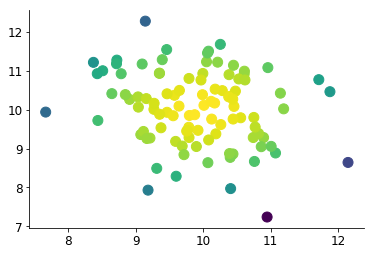

H tf.Tensor(2.7955897, shape=(), dtype=float32)
term2 tf.Tensor(-99.18028, shape=(), dtype=float32)
H tf.Tensor(2.7962568, shape=(), dtype=float32)
term2 tf.Tensor(-99.16397, shape=(), dtype=float32)
H tf.Tensor(2.8099947, shape=(), dtype=float32)
term2 tf.Tensor(-99.02789, shape=(), dtype=float32)
H tf.Tensor(2.824588, shape=(), dtype=float32)
term2 tf.Tensor(-99.124084, shape=(), dtype=float32)
H tf.Tensor(2.847312, shape=(), dtype=float32)
term2 tf.Tensor(-98.91727, shape=(), dtype=float32)
H tf.Tensor(2.861248, shape=(), dtype=float32)
term2 tf.Tensor(-98.90242, shape=(), dtype=float32)
H tf.Tensor(2.8662229, shape=(), dtype=float32)
term2 tf.Tensor(-98.85658, shape=(), dtype=float32)
H tf.Tensor(2.8597398, shape=(), dtype=float32)
term2 tf.Tensor(-98.7271, shape=(), dtype=float32)
H tf.Tensor(2.8325706, shape=(), dtype=float32)
term2 tf.Tensor(-98.85316, shape=(), dtype=float32)
H tf.Tensor(2.795953, shape=(), dtype=float32)
term2 tf.Tensor(-99.07455, shape=(), dtype=float32)
H tf

H tf.Tensor(2.7665784, shape=(), dtype=float32)
term2 tf.Tensor(-98.85144, shape=(), dtype=float32)
H tf.Tensor(2.7753823, shape=(), dtype=float32)
term2 tf.Tensor(-99.07385, shape=(), dtype=float32)
H tf.Tensor(2.7901304, shape=(), dtype=float32)
term2 tf.Tensor(-98.993835, shape=(), dtype=float32)
H tf.Tensor(2.8026085, shape=(), dtype=float32)
term2 tf.Tensor(-98.96838, shape=(), dtype=float32)
H tf.Tensor(2.8109863, shape=(), dtype=float32)
term2 tf.Tensor(-99.1276, shape=(), dtype=float32)
H tf.Tensor(2.8288436, shape=(), dtype=float32)
term2 tf.Tensor(-98.949745, shape=(), dtype=float32)
H tf.Tensor(2.8409975, shape=(), dtype=float32)
term2 tf.Tensor(-98.790665, shape=(), dtype=float32)
H tf.Tensor(2.8351243, shape=(), dtype=float32)
term2 tf.Tensor(-99.046265, shape=(), dtype=float32)
H tf.Tensor(2.8334208, shape=(), dtype=float32)
term2 tf.Tensor(-99.04974, shape=(), dtype=float32)
H tf.Tensor(2.835761, shape=(), dtype=float32)
term2 tf.Tensor(-99.116714, shape=(), dtype=float3

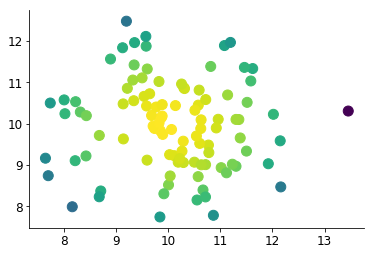

H tf.Tensor(2.868063, shape=(), dtype=float32)
term2 tf.Tensor(-98.94393, shape=(), dtype=float32)
H tf.Tensor(2.8569667, shape=(), dtype=float32)
term2 tf.Tensor(-98.933914, shape=(), dtype=float32)
H tf.Tensor(2.8413105, shape=(), dtype=float32)
term2 tf.Tensor(-98.83829, shape=(), dtype=float32)
H tf.Tensor(2.8138607, shape=(), dtype=float32)
term2 tf.Tensor(-99.12796, shape=(), dtype=float32)
H tf.Tensor(2.799909, shape=(), dtype=float32)
term2 tf.Tensor(-99.092896, shape=(), dtype=float32)
H tf.Tensor(2.794923, shape=(), dtype=float32)
term2 tf.Tensor(-99.027916, shape=(), dtype=float32)
H tf.Tensor(2.7928433, shape=(), dtype=float32)
term2 tf.Tensor(-99.02815, shape=(), dtype=float32)
H tf.Tensor(2.793517, shape=(), dtype=float32)
term2 tf.Tensor(-99.11294, shape=(), dtype=float32)
H tf.Tensor(2.8035054, shape=(), dtype=float32)
term2 tf.Tensor(-98.96397, shape=(), dtype=float32)
H tf.Tensor(2.8098876, shape=(), dtype=float32)
term2 tf.Tensor(-98.858444, shape=(), dtype=float32)


H tf.Tensor(2.8840833, shape=(), dtype=float32)
term2 tf.Tensor(-99.08986, shape=(), dtype=float32)
H tf.Tensor(2.8847713, shape=(), dtype=float32)
term2 tf.Tensor(-99.039536, shape=(), dtype=float32)
H tf.Tensor(2.8886585, shape=(), dtype=float32)
term2 tf.Tensor(-98.689224, shape=(), dtype=float32)
H tf.Tensor(2.8687944, shape=(), dtype=float32)
term2 tf.Tensor(-98.99798, shape=(), dtype=float32)
H tf.Tensor(2.8509057, shape=(), dtype=float32)
term2 tf.Tensor(-98.95141, shape=(), dtype=float32)
H tf.Tensor(2.830634, shape=(), dtype=float32)
term2 tf.Tensor(-99.16757, shape=(), dtype=float32)
H tf.Tensor(2.826558, shape=(), dtype=float32)
term2 tf.Tensor(-99.002304, shape=(), dtype=float32)
H tf.Tensor(2.823173, shape=(), dtype=float32)
term2 tf.Tensor(-98.901115, shape=(), dtype=float32)
H tf.Tensor(2.8113866, shape=(), dtype=float32)
term2 tf.Tensor(-98.93382, shape=(), dtype=float32)
H tf.Tensor(2.794771, shape=(), dtype=float32)
term2 tf.Tensor(-98.7914, shape=(), dtype=float32)
H

In [5]:
num_iters = 1000
for i in range(num_iters):
    start_time = time.time()
    loss = train_step()
    end_time = time.time()
    if (i % 100 == 0):
        print(i, loss, 'took %.4f seconds' % (end_time-start_time))
        x, H = dn(N)
        plt.figure()
        plt.scatter(x[:,0], x[:,1], c=dn.log_prob(x))
        plt.show()